In [1]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score

# show all
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# pd.set_option('display.max_colwidth', None)
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.shape
train.sample(5)

(159571, 8)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
137628,e0734284be9cf1a1,Please stop. If you continue to vandalize page...,0,0,0,0,0,0
118222,77bb906d6e8a1289,Lack of compatibility between versions \n\nI t...,0,0,0,0,0,0
37075,62f77a9618f6f8e0,"Hey, sorry to just throw this any old were, an...",0,0,0,0,0,0
143554,ffafbd7d44b26b11,"This article is a list of cities by area, not ...",0,0,0,0,0,0
17291,2da4dc04f7894549,"The statement above, from Jayron32 is not true...",0,0,0,0,0,0


In [3]:
cols_target = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
unlabelled_in_all = train[(train['toxic']!=1) & (train['severe_toxic']!=1) & (train['obscene']!=1) & 
                            (train['threat']!=1) & (train['insult']!=1) & (train['identity_hate']!=1)]

print('unlabelled comment', len(unlabelled_in_all)/len(train)*100)

unlabelled comment 89.83211235124176


In [5]:
print('Total row in train:{}'.format(len(train)))
print('Total row in test:{}'.format(len(test)))

train[cols_target].sum()

Total row in train:159571
Total row in test:153164


toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [6]:
# look at the character length for the rows in the training data and record these
train['char_length'] = train['comment_text'].apply(lambda x: len(str(x)))
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,char_length
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,264
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,112
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,233
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,622
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,67


<AxesSubplot:>

<function matplotlib.pyplot.show(close=None, block=None)>

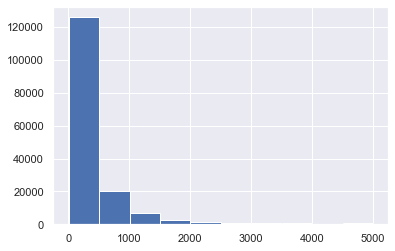

In [7]:
# histogram plot for tex length
sns.set()
train['char_length'].hist()
plt.show

<Figure size 504x504 with 0 Axes>

Text(0.5, 1.05, 'Correlation of feature & target')

<AxesSubplot:title={'center':'Correlation of feature & target'}>

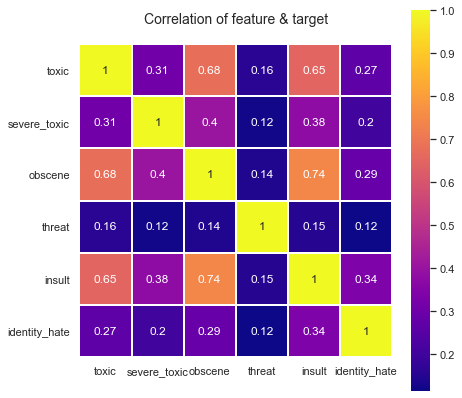

In [8]:
# heatmap for correlations
data = train[cols_target]

colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of feature & target', y = 1.05, size = 14)
sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap = colormap
            , linecolor='white', annot=True)

In [9]:
# Text cleaning 
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [10]:
# Clean the comment text in train and test
train['comment_text'] = train['comment_text'].map(lambda com : clean_text(com))
test['comment_text'] = test['comment_text'].map(lambda com : clean_text(com))
# type(train) still df

# train_text = list(train['comment_text'])
# test_text = list(test['comment_text'])
# train_clean = clean_text(train_text)
# test_clean = clean_text(test_text)
# type(train_clean) = list


In [11]:
# Define X from entire train & test data for use in tokenization by Vectorizer
train = train.drop('char_length', axis = 1)

In [12]:
X = train.comment_text
test_X = test.comment_text
type(X)
X
X.shape
test_X.shape

pandas.core.series.Series

0         explanation why the edits made under my userna...
1         d aww he matches this background colour i am s...
2         hey man i am really not trying to edit war it ...
3         more i cannot make any real suggestions on imp...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself that is a ho...
159568    spitzer umm theres no actual article for prost...
159569    and it looks like it was actually you who put ...
159570    and i really do not think you understand i cam...
Name: comment_text, Length: 159571, dtype: object

(159571,)

(153164,)

In [13]:
# Vectorize the data
# import and instantiate TfidfVectorizer

vect = TfidfVectorizer(max_features=5000, stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [14]:
X_dtm = vect.fit_transform(X)
test_X_dtm = vect.transform(test_X)

X_dtm
test_X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178792 stored elements in Compressed Sparse Row format>

<153164x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 2618972 stored elements in Compressed Sparse Row format>

In [15]:
sub = pd.read_csv('sample_submission.csv', encoding='utf-8')
sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.5,0.5,0.5,0.5,0.5,0.5
1,0000247867823ef7,0.5,0.5,0.5,0.5,0.5,0.5
2,00013b17ad220c46,0.5,0.5,0.5,0.5,0.5,0.5
3,00017563c3f7919a,0.5,0.5,0.5,0.5,0.5,0.5
4,00017695ad8997eb,0.5,0.5,0.5,0.5,0.5,0.5


In [16]:
# Binary Relevance
# A multi-label classifier using Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

for label in cols_target:
    print('Processing {}'.format(label))
    y = train[label]
    
    # train the model useing X_dtm & y
    logreg.fit(X_dtm, y)
    
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    
    # compute the predicted probabilities for X_text_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm)[:, 1]
    sub[label] = test_y_prob

Processing toxic


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9639533499194716
Processing severe_toxic


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9920724943755445
Processing obscene


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9832363023356374
Processing threat


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9981199591404453
Processing insult


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9755344016143285
Processing identity_hate


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9939713356436947


In [17]:
sub.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999958,0.460113,0.999965,0.050123,0.972258,0.427688
1,0000247867823ef7,0.002460,0.000443,0.000402,0.000324,0.003252,0.000411
2,00013b17ad220c46,0.010815,0.000117,0.003209,0.000035,0.007652,0.001254
3,00017563c3f7919a,0.001347,0.002156,0.000974,0.000117,0.000835,0.000033
4,00017695ad8997eb,0.019374,0.000811,0.001252,0.000602,0.003271,0.000557


In [18]:
sub_chain = pd.read_csv('sample_submission.csv', encoding='utf-8')

In [19]:
# Classifier Chains 
# Multi-Label classifier using Logistic Regression

# create a function to add features
def add_feature(X, feature_to_add):
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [20]:
for label in cols_target:
    print('Processing {}'.format(label))
    y = train[label]
    
    # train the model useing X_dtm & y
    logreg.fit(X_dtm, y)
    
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    
    # make predictions from text_X
    test_y = logreg.predict(test_X_dtm)
    test_y_prob = logreg.predict_proba(test_X_dtm)[:, 1]
    sub_chain[label] = test_y_prob
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm, y)
    print("Shape of X_dtm is now {}".format(X_dtm.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm.shape))

Processing toxic


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9639533499194716
Shape of X_dtm is now (159571, 5001)
Shape of test_X_dtm is now (153164, 5001)
Processing severe_toxic


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9925926390133546
Shape of X_dtm is now (159571, 5002)
Shape of test_X_dtm is now (153164, 5002)
Processing obscene


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.985078742378001
Shape of X_dtm is now (159571, 5003)
Shape of test_X_dtm is now (153164, 5003)
Processing threat


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9984144988751089
Shape of X_dtm is now (159571, 5004)
Shape of test_X_dtm is now (153164, 5004)
Processing insult


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9825218868090067
Shape of X_dtm is now (159571, 5005)
Shape of test_X_dtm is now (153164, 5005)
Processing identity_hate


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9956195047972376
Shape of X_dtm is now (159571, 5006)
Shape of test_X_dtm is now (153164, 5006)


In [21]:
sub_chain.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999958,4.349257e-01,0.999688,0.083935,0.853219,0.494774
1,0000247867823ef7,0.002460,2.113165e-06,0.000244,0.000078,0.003109,0.000162
2,00013b17ad220c46,0.010815,6.339094e-07,0.000863,0.000012,0.002727,0.000584
3,00017563c3f7919a,0.001347,3.144460e-05,0.001043,0.000060,0.000514,0.000004
4,00017695ad8997eb,0.019374,2.065961e-06,0.000303,0.000162,0.001012,0.000110


In [41]:
# Combine
sub_com = pd.read_csv('sample_submission.csv', encoding='utf-8')

# corr_trarget = ['obscence', 'insult', 'toxic']
for label in cols_target:
    sub_com[label] = 0.5*(sub_chain[label]+sub_chain[label])
    
sub_com.head(15)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999958,4.349257e-01,0.999688,0.083935,0.853219,0.494774
1,0000247867823ef7,0.002460,2.113165e-06,0.000244,0.000078,0.003109,0.000162
2,00013b17ad220c46,0.010815,6.339094e-07,0.000863,0.000012,0.002727,0.000584
3,00017563c3f7919a,0.001347,3.144460e-05,0.001043,0.000060,0.000514,0.000004
4,00017695ad8997eb,0.019374,2.065961e-06,0.000303,0.000162,0.001012,0.000110
5,0001ea8717f6de06,0.007827,3.310886e-06,0.001060,0.000032,0.005464,0.000059
6,00024115d4cbde0f,0.000348,1.452872e-06,0.000570,0.000005,0.000543,0.000043
7,000247e83dcc1211,0.686423,9.463948e-04,0.130695,0.003620,0.204150,0.000069
8,00025358d4737918,0.002239,5.699353e-06,0.012271,0.000598,0.000170,0.000036
9,00026d1092fe71cc,0.001289,1.265219e-06,0.000947,0.000064,0.001392,0.000086


In [23]:
MMA_dataset = pd.read_csv('MMA_Neg_classifier.csv'
                      , encoding='utf-8')
MMA_dataset.head()
MMA_dataset.shape

,text,sentiment
0,Now I understand #usada is n.1 bullshit people...,Negative
1,NY stand up \nDon’t miss #ufc229 press confere...,Negative
2,The Notorious and The Godfather. \nKiss on the...,Negative
3,Suck my blood. https://t.co/39bNB2XI5P,Negative
4,"Coach, today you closed me in the octagon wit...",Negative


(86158, 2)

In [24]:
MMA_dataset['text'] = MMA_dataset['text'].map(lambda com : clean_text(com))

In [25]:
X = train.comment_text
test_MMA = MMA_dataset.text
print(X.shape, test_MMA.shape)

(159571,) (86158,)


In [26]:
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(max_features=5000, stop_words='english')

In [27]:
# fit and transform train data
X_dtm_ = vect.fit_transform(X)
X_dtm_

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178792 stored elements in Compressed Sparse Row format>

In [28]:
# transform test data
test_X_dtm_ = vect.transform(test_MMA)
test_X_dtm_

<86158x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 595393 stored elements in Compressed Sparse Row format>

In [29]:
columns = ['text', 'sentiment', 'toxic', 'severe_toxic', 'obscene', 'threat'
           , 'insult', 'identity_hate']
MMA_text_classifier = pd.read_csv('MMA_Neg_LRmodel.csv'
                      , encoding='utf-8', names = columns)
# MMA_text_classifier.head()
MMA_text_classifier = MMA_text_classifier.drop(columns = ['sentiment'])
MMA_text_classifier = MMA_text_classifier.drop([0])
MMA_text_classifier.head()

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,Now I understand #usada is n.1 bullshit people...,NaN,NaN,NaN,NaN,NaN,NaN
2,NY stand up \nDon’t miss #ufc229 press confere...,NaN,NaN,NaN,NaN,NaN,NaN
3,The Notorious and The Godfather. \nKiss on the...,NaN,NaN,NaN,NaN,NaN,NaN
4,Suck my blood. https://t.co/39bNB2XI5P,NaN,NaN,NaN,NaN,NaN,NaN
5,"Coach, today you closed me in the octagon wit...",NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# import and instantiate the Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

for label in cols_target:
    print('Processing {}'.format(label))
    y = train[label]
    
    # train the model useing X_dtm & y
    logreg.fit(X_dtm_, y)
    
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm_)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    
    # compute the predicted probabilities for X_text_dtm
    test_y_prob = logreg.predict_proba(test_X_dtm_)[:, 1]
    MMA_text_classifier[label] = test_y_prob

Processing toxic


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9639533499194716
Processing severe_toxic


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9920724943755445
Processing obscene


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9832363023356374
Processing threat


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9981199591404453
Processing insult


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9755344016143285
Processing identity_hate


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9939713356436947


In [31]:
MMA_text_classifier.head()

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,Now I understand #usada is n.1 bullshit people...,0.995797,0.001574,0.969649,0.001944,0.126710,0.000148
2,NY stand up \nDon’t miss #ufc229 press confere...,0.039826,0.000511,0.000781,0.000096,0.001242,0.000416
3,The Notorious and The Godfather. \nKiss on the...,0.564377,0.004402,0.007727,0.003780,0.056310,0.000362
4,Suck my blood. https://t.co/39bNB2XI5P,0.998268,0.030973,0.568671,0.014879,0.360622,0.011664
5,"Coach, today you closed me in the octagon wit...",0.086476,0.000188,0.001345,0.000662,0.015617,0.003922


In [32]:
MMA_text_classifier.to_csv('MMA_Bin_classifier.csv',index=False)

In [33]:
columns = ['text', 'sentiment', 'toxic', 'severe_toxic', 'obscene', 'threat'
           , 'insult', 'identity_hate']
MMA_text_classifier_chain= pd.read_csv('MMA_Neg_LRmodel.csv'
                      , encoding='utf-8', names = columns)
# MMA_text_classifier.head()
MMA_text_classifier_chain = MMA_text_classifier_chain.drop(columns = ['sentiment'])
MMA_text_classifier_chain = MMA_text_classifier_chain.drop([0])
MMA_text_classifier_chain.head()

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,Now I understand #usada is n.1 bullshit people...,NaN,NaN,NaN,NaN,NaN,NaN
2,NY stand up \nDon’t miss #ufc229 press confere...,NaN,NaN,NaN,NaN,NaN,NaN
3,The Notorious and The Godfather. \nKiss on the...,NaN,NaN,NaN,NaN,NaN,NaN
4,Suck my blood. https://t.co/39bNB2XI5P,NaN,NaN,NaN,NaN,NaN,NaN
5,"Coach, today you closed me in the octagon wit...",NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Classifier Chains 
# Multi-Label classifier using Logistic Regression

# create a function to add features
def add_feature(X, feature_to_add):
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [35]:
for label in cols_target:
    print('Processing {}'.format(label))
    y = train[label]
    
    # train the model useing X_dtm & y
    logreg.fit(X_dtm_, y)
    
    # compute the training accuracy
    y_pred_X = logreg.predict(X_dtm_)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    
    # make predictions from text_X
    test_y = logreg.predict(test_X_dtm_)
    test_y_prob = logreg.predict_proba(test_X_dtm_)[:, 1]
    MMA_text_classifier_chain[label] = test_y_prob
    # chain current label to X_dtm
    X_dtm = add_feature(X_dtm_, y)
    print("Shape of X_dtm is now {}".format(X_dtm_.shape))
    # chain current label predictions to test_X_dtm
    test_X_dtm = add_feature(test_X_dtm_, test_y)
    print('Shape of test_X_dtm is now {}'.format(test_X_dtm_.shape))

Processing toxic


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9639533499194716
Shape of X_dtm is now (159571, 5000)
Shape of test_X_dtm is now (86158, 5000)
Processing severe_toxic


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9920724943755445
Shape of X_dtm is now (159571, 5000)
Shape of test_X_dtm is now (86158, 5000)
Processing obscene


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9832363023356374
Shape of X_dtm is now (159571, 5000)
Shape of test_X_dtm is now (86158, 5000)
Processing threat


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9981199591404453
Shape of X_dtm is now (159571, 5000)
Shape of test_X_dtm is now (86158, 5000)
Processing insult


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9755344016143285
Shape of X_dtm is now (159571, 5000)
Shape of test_X_dtm is now (86158, 5000)
Processing identity_hate


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=12.0)

Training accuracy is 0.9939713356436947
Shape of X_dtm is now (159571, 5000)
Shape of test_X_dtm is now (86158, 5000)


In [42]:
MMA_text_classifier_chain.head(15)

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,Now I understand #usada is n.1 bullshit people...,0.995797,0.001574,0.969649,0.001944,0.126710,0.000148
2,NY stand up \nDon’t miss #ufc229 press confere...,0.039826,0.000511,0.000781,0.000096,0.001242,0.000416
3,The Notorious and The Godfather. \nKiss on the...,0.564377,0.004402,0.007727,0.003780,0.056310,0.000362
4,Suck my blood. https://t.co/39bNB2XI5P,0.998268,0.030973,0.568671,0.014879,0.360622,0.011664
5,"Coach, today you closed me in the octagon wit...",0.086476,0.000188,0.001345,0.000662,0.015617,0.003922
6,Go to room 112. Tell them blanco sent you.,0.020406,0.000774,0.041848,0.000616,0.013436,0.000843
7,@blakeillg21 @hunter_win @TheNotoriousMMA You ...,0.170822,0.019530,0.015248,0.000368,0.030652,0.003344
8,#UFC229 prelim picks :\n\nHoltzman in a decisi...,0.001066,0.000356,0.001617,0.000579,0.001774,0.001373
9,So it turns out that the only way to watch the...,0.110875,0.000711,0.029038,0.000729,0.003915,0.003653
10,Fight night! #nevada #ufc #tmobilearena #bts #...,0.045616,0.000562,0.007972,0.000060,0.005673,0.002614


In [37]:
columns = ['text', 'sentiment', 'toxic', 'severe_toxic', 'obscene', 'threat'
           , 'insult', 'identity_hate']
Final_MMA_Classify = pd.read_csv('MMA_Neg_LRmodel.csv'
                      , encoding='utf-8', names = columns)
# MMA_text_classifier.head()
Final_MMA_Classify = Final_MMA_Classify.drop(columns = ['sentiment'])
Final_MMA_Classify = Final_MMA_Classify.drop([0])
Final_MMA_Classify.head()

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,Now I understand #usada is n.1 bullshit people...,NaN,NaN,NaN,NaN,NaN,NaN
2,NY stand up \nDon’t miss #ufc229 press confere...,NaN,NaN,NaN,NaN,NaN,NaN
3,The Notorious and The Godfather. \nKiss on the...,NaN,NaN,NaN,NaN,NaN,NaN
4,Suck my blood. https://t.co/39bNB2XI5P,NaN,NaN,NaN,NaN,NaN,NaN
5,"Coach, today you closed me in the octagon wit...",NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
# corr_targets = ['obscene','insult','toxic']
for label in cols_target:
    Final_MMA_Classify[label] = 0.5*(MMA_text_classifier_chain[label]+MMA_text_classifier[label])

In [39]:
Final_MMA_Classify.head()

,text,toxic,severe_toxic,obscene,threat,insult,identity_hate
1,Now I understand #usada is n.1 bullshit people...,0.995797,0.001574,0.969649,0.001944,0.126710,0.000148
2,NY stand up \nDon’t miss #ufc229 press confere...,0.039826,0.000511,0.000781,0.000096,0.001242,0.000416
3,The Notorious and The Godfather. \nKiss on the...,0.564377,0.004402,0.007727,0.003780,0.056310,0.000362
4,Suck my blood. https://t.co/39bNB2XI5P,0.998268,0.030973,0.568671,0.014879,0.360622,0.011664
5,"Coach, today you closed me in the octagon wit...",0.086476,0.000188,0.001345,0.000662,0.015617,0.003922


In [40]:
Final_MMA_Classify.to_csv('MMA_Final_classifier.csv',index=False)